In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from phantasy import caget

# This template is created for objFunc version 1.0.3.

In [5]:
import objFuncs
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history

objFuncs version: 1.0.3. updated on 2024-03-11


# check machineIO, source and beam 

In [6]:
objFuncs._global_machineIO._test = True
objFuncs._global_machineIO._ensure_set_timeout = 30
objFuncs._global_machineIO._fetch_data_time_span = 10.0
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 1.0
objFuncs._global_machineIO.view()

   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 1.0
   _fetch_data_time_span : 10.0
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False
   history : {}
   _test : True


In [7]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
# Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
Q = round(caget("ACC_OPS:BEAM:Q_STRIP"))
A = int(caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK"))
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

124Xe49 A/Q= 2.5306122448979593


# preprare objective (for residual construction)

In [8]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+'][LSQ][FS1][after1stDipole]QuadCentering'
fname

'20240317_1524[124Xe49][LSQ][FS1][after1stDipole]QuadCentering'

In [6]:
decision_CSETs=[
    'FS1_CSS:PSC2_D2381:I_CSET',
#     'FS1_BBS:PSD_D2394:I_CSET',
    'FS1_BBS:PSC2_D2412:I_CSET',
#     'FS1_CSS:PSC1_D2381:I_CSET',
#     'FS1_BBS:PSC1_D2412:I_CSET'
]

decision_min = []
decision_max = []
for PV in decision_CSETs:
    x0 = caget(PV)
#     print(PV,x0)
#     caput(PV,0)
#     x0 = 0
    if 'PSC' in PV:
        decision_min += [x0 -5*AQ]
        decision_max += [x0 +5*AQ]
    elif 'PSD' in PV:
        decision_min += [x0* 0.9992]
        decision_max += [x0* 1.0008]


print(f'decision_min: {decision_min}')
print(f'decision_max: {decision_max}')

decision_min: [-16.517061224489797, -12.653061224489797]
decision_max: [8.789061224489796, 12.653061224489797]


In [7]:
objective_goal = { 
    'FS1_BBS:BPM_D2466:XPOS_RD' : 0.0,
    'FS1_BMS:BPM_D2502:XPOS_RD' : 0.0,
    'FS1_BMS:BPM_D2537:XPOS_RD' : 0.0,
}

objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

In [8]:
conditional_SETs = {
    'FS1_BBS:PSQ_D2416:I_CSET':[],
    'FS1_BBS:PSQ_D2424:I_CSET':[],
}

In [9]:
# 2-point lumped Q-scan
for i,PV in enumerate(conditional_SETs.keys()):
    x0 = caget(PV)
    conditional_SETs[PV] = [x0]*2
    conditional_SETs[PV][1] = x0 + 5*AQ

In [10]:
# # 3-point lumped Q-scan
# for i,PV in enumerate(conditional_SETs.keys()):
#     x0 = caget(PV)
#     conditional_SETs[PV] = [x0]*3
#     conditional_SETs[PV][1] = x0 - 5*AQ
#     conditional_SETs[PV][2] = x0 + 5*AQ

In [11]:
# # 2-point Q-scan
# for i,PV in enumerate(conditional_SETs.keys()):
#     x0 = caget(PV)
#     conditional_SETs[PV] = [x0]*(len(conditional_SETs)+1)
#     conditional_SETs[PV][i+1] = x0 + 20 #10*AQ

In [12]:
# # 3-point Q-scan
# for i,PV in enumerate(conditional_SETs.keys()):
#     x0 = caget(PV)
#     conditional_SETs[PV] = [x0]*(2*len(conditional_SETs)+1)
#     conditional_SETs[PV][2*i+1] = x0 - 3*AQ
#     conditional_SETs[PV][2*i+2] = x0 + 3*AQ

In [13]:
n_condition = len(list(conditional_SETs.values())[0])
conditional_SETs

{'FS1_BBS:PSQ_D2416:I_CSET': [137.225, 149.87806122448978],
 'FS1_BBS:PSQ_D2424:I_CSET': [61.485, 74.1380612244898]}

In [14]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min = decision_min,
    decision_max =  decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

======== class info ========
init_time: 2024-03-17 13:52:28.137194
class_hierarchy: [
    residualObjMultiConditionalVar, residualObjMultiConditional, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fb0606f2450>
decision_CSETs: [
    FS1_CSS:PSC2_D2381:I_CSET, FS1_BBS:PSC2_D2412:I_CSET]
decision_min: [-16.51706122 -12.65306122]
decision_max: [ 8.78906122 12.65306122]
decision_bounds: [[-16.51706122   8.78906122]
 [-12.65306122  12.65306122]]
decision_RDs: [
    FS1_CSS:PSC2_D2381:I_RD, FS1_BBS:PSC2_D2412:I_RD]
decision_tols: [1. 2.]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [-3.864  0.   ]

[condition_controller] ======== class info ========
init_time: 2024-03-17 13:52:31.153562
class_hierarchy: [
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fb05c364cd0>
decision_CSETs: [
    FS1_BBS:PSQ_D2416:I_CSET, FS1_BBS:PSQ_D2424:I_CSET]
decisi

In [15]:
plot_decision = plot_obj_history(
    res.history['decision_CSETs'],
    keys = [[k for k in decision_CSETs if 'PSD' in k],[k for k in decision_CSETs if 'PSC' in k]],
    title='decision_CSETs',
)
plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)

plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)

callbacks = [plot_decision,plot_conditions_RDs,plot_objectives_var]
# callbacks = []

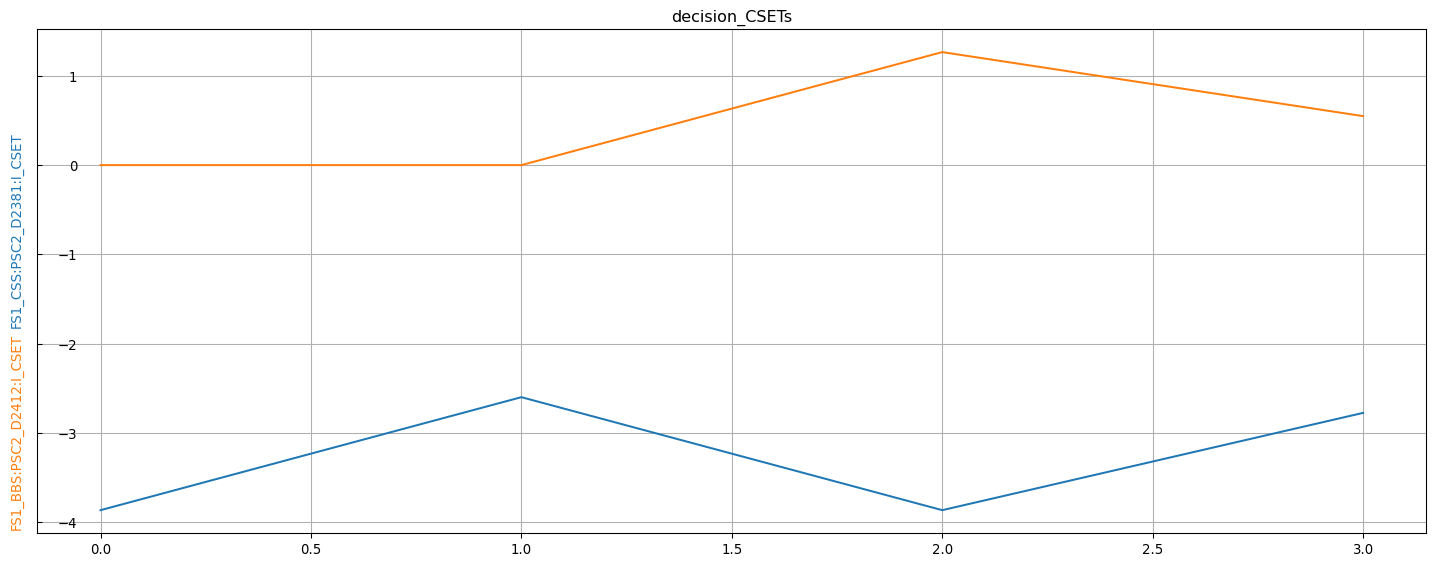

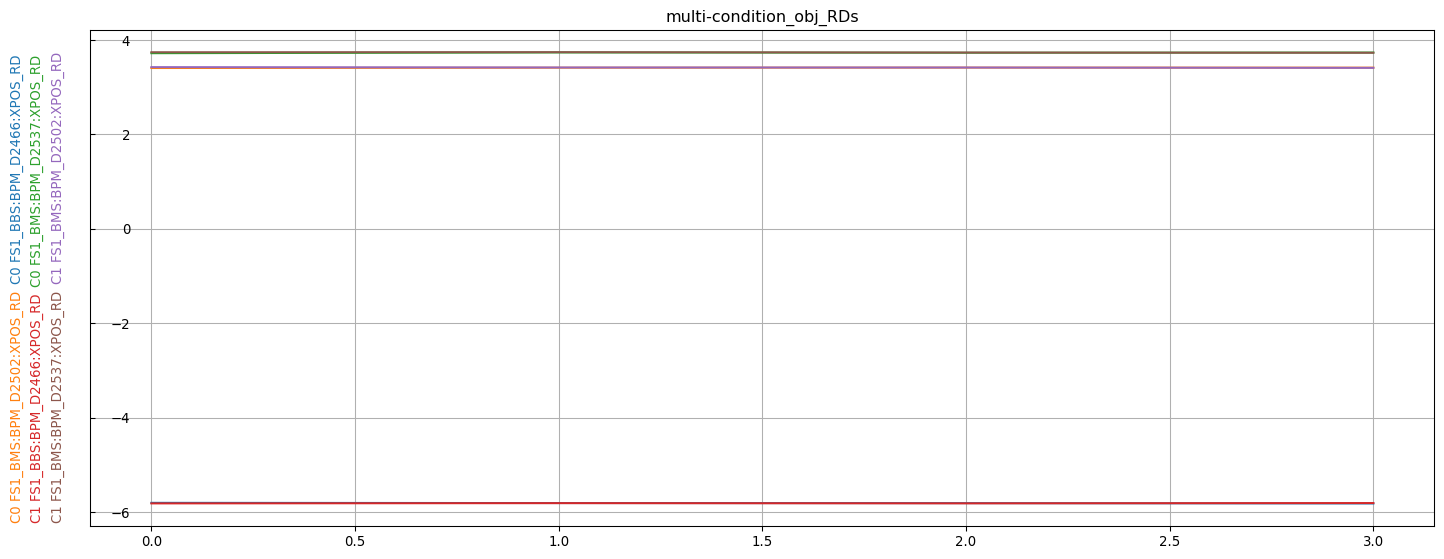

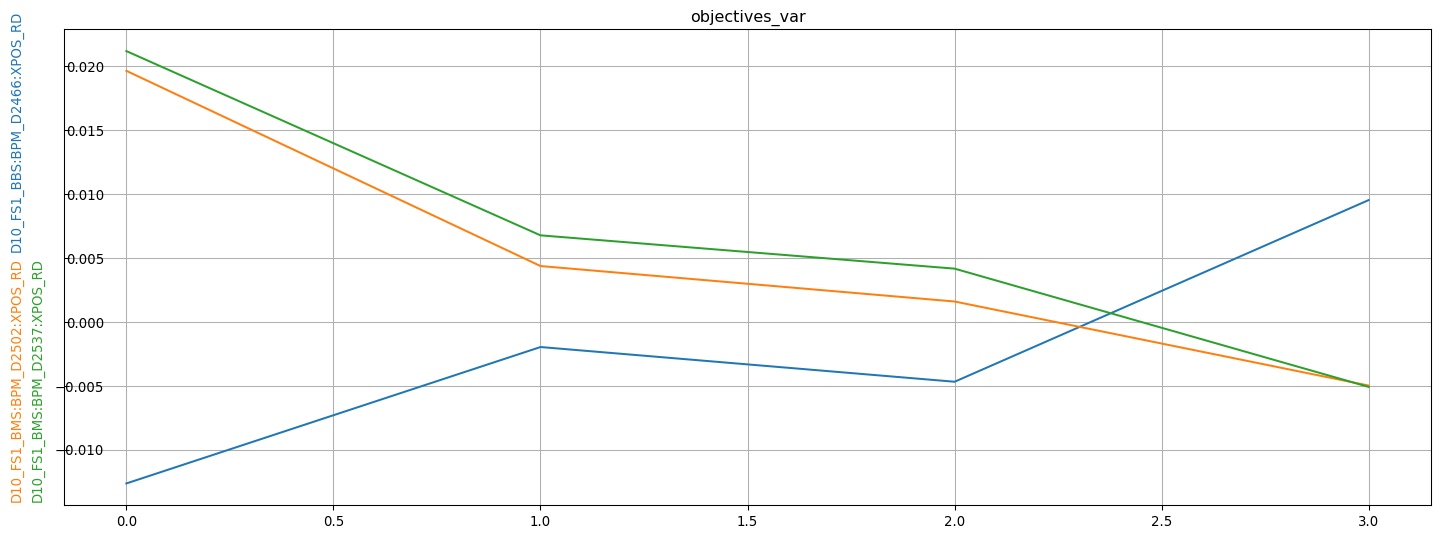

In [16]:
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
# res.condition_controller._set_decision(res.condition_controller.x0)
for f in callbacks:
    f.close()

In [17]:
res.condition_controller._set_decision(res.condition_controller.x0)

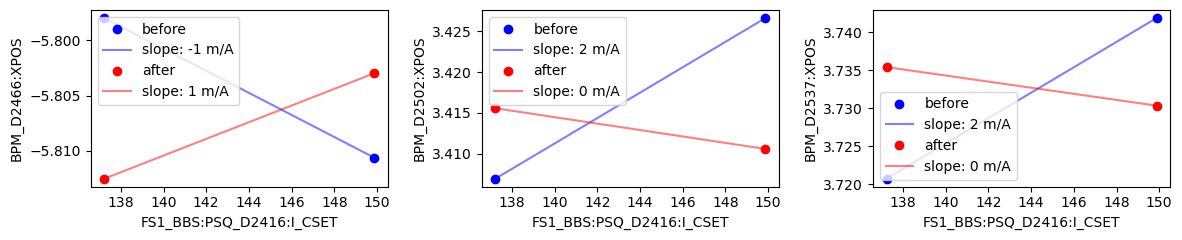

In [19]:
nobj = len(res.objective_RDs)
condition_label, condition_vals = list(res.conditional_SETs.items())[0]
fig,ax = plt.subplots(1,nobj,figsize=(4*nobj,2.5))

ylims = []
for iobj in range(nobj):
    values = []
    for icond in range(n_condition):
        values.append(res.history['condition'+str(icond)]['objective_RDs']['values'][0][iobj])
    ax[iobj].plot(condition_vals,values,'o',color='b',label='before')
    p = np.polyfit(condition_vals,values,deg=1)
    ax[iobj].plot(condition_vals,p[0]*np.array(condition_vals)+p[1],color='b',alpha=0.5,label='slope: '+str(round(p[0]*1000))+' m/A')
    
    values = []
    for icond in range(n_condition):
        values.append(res.history['condition'+str(icond)]['objective_RDs']['values'][-1][iobj])
    ax[iobj].plot(condition_vals,values,'o',color='r',label='after')
    p = np.polyfit(condition_vals,values,deg=1)
    ax[iobj].plot(condition_vals,p[0]*np.array(condition_vals)+p[1],color='r',alpha=0.5,label='slope: '+str(round(p[0]*1000))+' m/A')
    ax[iobj].legend()
    ax[iobj].set_xlabel(condition_label)
    ylabel = objective_RDs[iobj]
    ylabel = ylabel[ylabel.find(':')+1:-3]
    ax[iobj].set_ylabel(ylabel)
    
fig.tight_layout()

In [ ]:
res.save(fname+'.json')

In [ ]:
# objectives_var_hist = [np.sum(res.history['objectives_var']['values'][i]**2) for i in range(len(res.history['objectives_var']['values']))]
# imin = np.argmin(objectives_var_hist)
# x_best = res.history['decision_CSETs']['values'][imin]
# res(x_best)

In [ ]:
# objectives_var_hist = [np.sum(res.history['objectives_var']['values'][i]**2) for i in range(len(res.history['objectives_var']['values']))]
# objectives_var_hist